In [14]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import gc; gc.enable() 
print(os.listdir("../input/airbus-ship-detection"))

['test_v2', 'sample_submission_v2.csv', 'train_ship_segmentations_v2.csv', 'train_v2']


In [15]:
masks = pd.read_csv(os.path.join('../input/airbus-ship-detection', 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')#非空图片中的mask数量
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')#所有图片中非空图片
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [16]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head()

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


In [17]:
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids.head()

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [18]:
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

unique_img_ids.head()

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0


In [19]:
ship_dir = '../input/airbus-ship-detection'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids.head()

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
0,00003e153.jpg,0,0.0,[0.0],128.944336
1,0001124c7.jpg,0,0.0,[0.0],76.059570
2,000155de5.jpg,1,1.0,[1.0],147.625977
3,000194a2d.jpg,5,1.0,[1.0],75.221680
4,0001b1832.jpg,0,0.0,[0.0],95.627930


Text(0.5, 1.0, 'Number of images of each size')

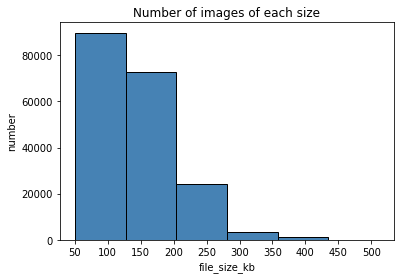

In [20]:
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
plt.hist(x = unique_img_ids['file_size_kb'], # 指定绘图数据
           bins = 6, # 指定直方图中条块的个数
           color = 'steelblue', # 指定直方图的填充色
           edgecolor = 'black' # 指定直方图的边框色
          )
plt.xticks([50,100,150,200,250,300,350,400,450,500])
plt.ylabel("number")
plt.xlabel('file_size_kb')
#unique_img_ids['file_size_kb'].hist()#绘制直方图
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)
plt.title("Number of images of each size")

In [21]:
print(unique_img_ids['ships'].value_counts())

0     149293
1      26737
2       7563
3       2908
4       1608
5        917
6        652
7        405
8        314
9        241
10       168
11       144
12       122
14        76
13        75
15        66
Name: ships, dtype: int64


In [22]:
train_0 = unique_img_ids[unique_img_ids['ships']==1].sample(1800)
train_1 = unique_img_ids[unique_img_ids['ships']==2].sample(1800)
train_2 = unique_img_ids[unique_img_ids['ships']==3].sample(1800)

In [23]:
train_3 = unique_img_ids[unique_img_ids['ships']!=3]
train_3 = train_3[unique_img_ids['ships']!=2]
train_3 = train_3[unique_img_ids['ships']!=1]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
unique_img_ids=pd.concat([train_0,train_1,train_2,train_3])

20188 images (20188, 5)


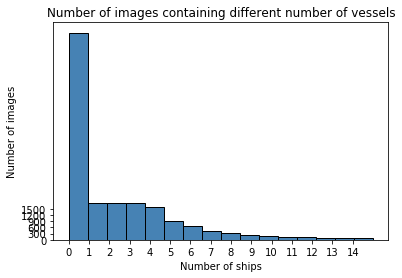

In [25]:
SAMPLES_PER_GROUP = 10000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
#图片有相同船舶数量，但超出2000的不要
rect=plt.hist(x = balanced_train_df['ships'], # 指定绘图数据
           bins = 16, # 指定直方图中条块的个数
           color = 'steelblue', # 指定直方图的填充色
           edgecolor = 'black' # 指定直方图的边框色
          )
plt.yticks(range(0,1800,300))
plt.xticks(range(0,15))
plt.ylabel("Number of images")
plt.xlabel('Number of ships')
plt.title("Number of images containing different number of vessels")
#balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'images',balanced_train_df.shape)#取出1万张图片


In [26]:
from PIL import Image
x = np.empty(shape=(20188, 256,256,3),dtype=np.uint8)
y = np.empty(shape=20188,dtype=np.uint8)
for index, image in enumerate(balanced_train_df['ImageId']):
    image_array= Image.open('../input/airbus-ship-detection/train_v2/' + image).resize((256,256)).convert('RGB')
    x[index] = image_array
    y[index]=balanced_train_df[balanced_train_df['ImageId']==image]['has_ship'].iloc[0]

print(x.shape)
print(y.shape)

(20188, 256, 256, 3)
(20188,)


In [27]:
#Set target to one hot target for classification problem
#为分类问题将目标设置为一个热目标
from sklearn.preprocessing import OneHotEncoder
y_targets =y.reshape(len(y),-1)
enc = OneHotEncoder()
enc.fit(y_targets)
y = enc.transform(y_targets).toarray()
print(y.shape)

(20188, 2)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val  = train_test_split(x,y,test_size = 0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((16150, 256, 256, 3), (4038, 256, 256, 3), (16150, 2), (4038, 2))

In [29]:
import keras.applications
print(dir( keras.applications))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'absolute_import', 'backend', 'densenet', 'division', 'inception_resnet_v2', 'inception_v3', 'keras_applications', 'keras_modules_injection', 'layers', 'mobilenet', 'mobilenet_v2', 'models', 'nasnet', 'print_function', 'resnet', 'resnet50', 'resnet_v2', 'utils', 'vgg16', 'vgg19', 'xception']


In [30]:
from keras.applications.vgg19 import VGG19 as PTModel

#from keras.applications.resnet50 import ResNet50 as PTModel

#from keras.applications.inception_v3 import InceptionV3 as PTModel

#from keras.applications.xception import Xception as PTModel

#from keras.applications.densenet import DenseNet169 as PTModel

#from keras.applications.densenet import DenseNet121 as PTModel

#from keras.applications.resnet50 import ResNet50 as PTModel

In [31]:
img_width, img_height = 256, 256
model = PTModel(weights = None, include_top=False, input_shape = (img_width, img_height, 3))
#weights=None，‘imagenet’表示不加载权重

In [32]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model 
from keras import backend as K
for layer in model.layers:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model创建最终模型
model_final = Model(input = model.input, output = predictions)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [33]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = np.argmax(np.asarray(self.model.predict(self.validation_data[0])), axis=1)
#         val_targ = self.validation_data[1]
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
#         print(' — val_f1:' ,_val_f1)
        return

metrics1 = Metrics()

In [34]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('boat_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat,metrics1]

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [35]:
from keras import optimizers
def fit():
    epochs = 20
    lrate = 0.01
    decay = lrate/epochs
    #adam = optimizers.Adam(lr=lrate,beta_1=0.9, beta_2=0.999, decay=decay)
    sgd = optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model_final.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    loss_history=[model_final.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=50,callbacks=callbacks_list)]
    
    return loss_history
num=0

while True:
    num=num+1
#     prefix='%d'%(num)
    loss_history = fit()
    model_final.save_weights('my_model_weights%d.h5'% num)
    if np.min([mh.history['val_loss'] for mh in loss_history]) < 0.01:
        break
    if num==1:
        break

Train on 16150 samples, validate on 4038 samples
Epoch 1/20
16150/16150 [==============================] - 100s 6ms/step - loss: 0.6823 - binary_accuracy: 0.5797 - val_loss: 0.6468 - val_binary_accuracy: 0.6152

Epoch 00001: val_loss improved from inf to 0.64680, saving model to boat_detector_weights.best.hdf5
— val_f1: 0.572316 — val_precision: 0.844538 — val_recall 0.294721
Epoch 2/20
16150/16150 [==============================] - 93s 6ms/step - loss: 0.6506 - binary_accuracy: 0.6370 - val_loss: 0.6167 - val_binary_accuracy: 0.6535

Epoch 00002: val_loss improved from 0.64680 to 0.61668, saving model to boat_detector_weights.best.hdf5
— val_f1: 0.628468 — val_precision: 0.843054 — val_recall 0.388563
Epoch 3/20
16150/16150 [==============================] - 93s 6ms/step - loss: 0.6279 - binary_accuracy: 0.6629 - val_loss: 0.5983 - val_binary_accuracy: 0.7046

Epoch 00003: val_loss improved from 0.61668 to 0.59832, saving model to boat_detector_weights.best.hdf5
— val_f1: 0.696573 — v

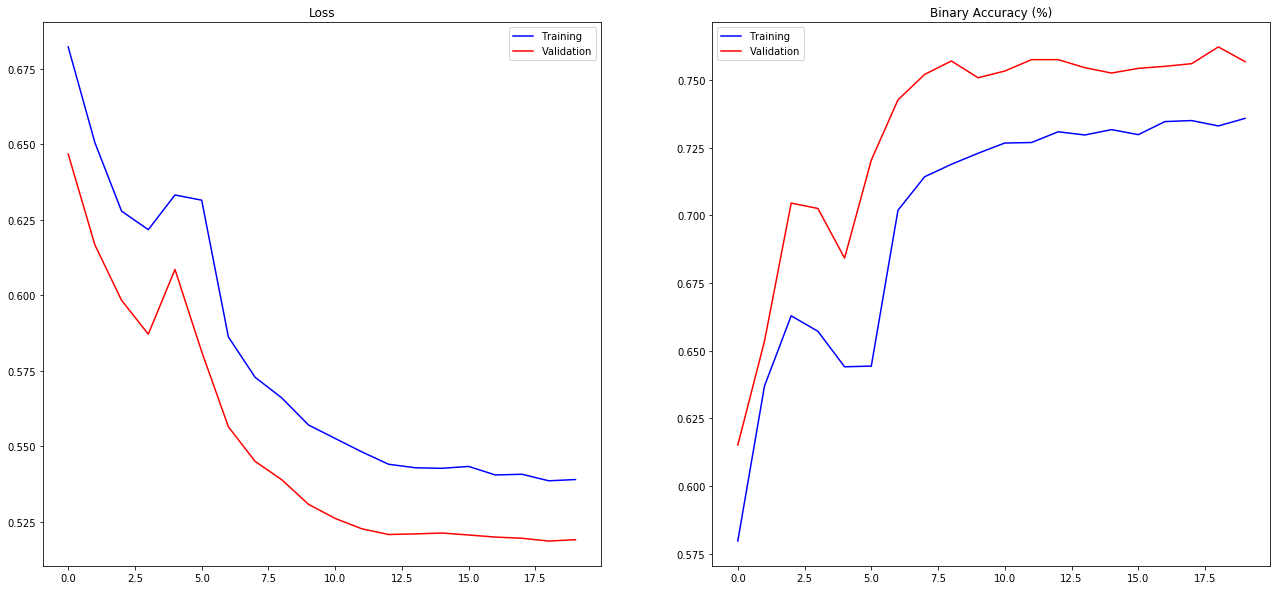

In [36]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])#图表，损失函数（训练和验证）的迭代图表
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])#准确率，（训练和迭代的）
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [37]:
unique_img_ids1 = unique_img_ids[20000:30000]

In [38]:
x_test = np.empty(shape=(10000, 256,256,3),dtype=np.uint8)#10680 256
y_test = np.empty(shape=10000,dtype=np.uint8)
for index, image in enumerate(unique_img_ids1['ImageId']):
    image_array= Image.open('../input/airbus-ship-detection/train_v2/' + image).resize((256,256)).convert('RGB') #256
    x_test[index] = image_array
    y_test[index]=unique_img_ids1[unique_img_ids1['ImageId']==image]['has_ship'].iloc[0]

print(x_test.shape)
print(y_test.shape)

KeyboardInterrupt: 

In [39]:
y_test_targets =y_test.reshape(len(y_test),-1)
enc = OneHotEncoder()
enc.fit(y_test_targets)
y_test = enc.transform(y_test_targets).toarray()
print(y_test.shape)

(10000, 255)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [40]:
predict_ship = model_final.evaluate( x_test,y_test)
acc=predict_ship[1]*100

ValueError: Error when checking target: expected dense_9 to have shape (2,) but got array with shape (255,)

In [41]:
print ('Accuracy of random data = '+ str(acc) + "%")

NameError: name 'acc' is not defined

Available keys in history.history: dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy', 'lr'])


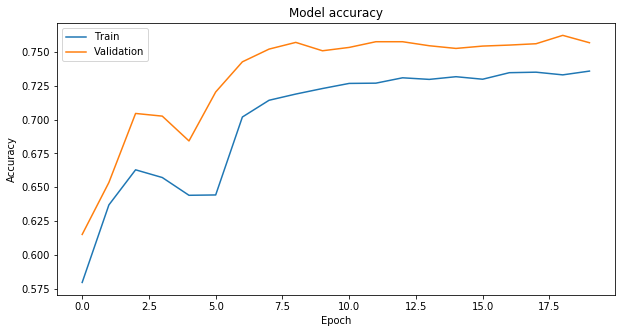

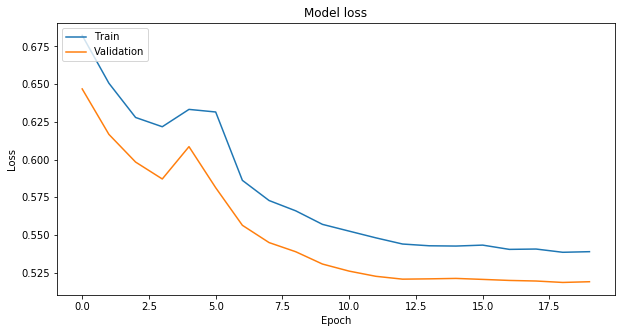

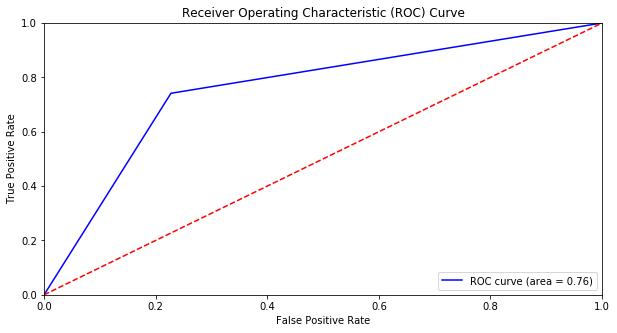

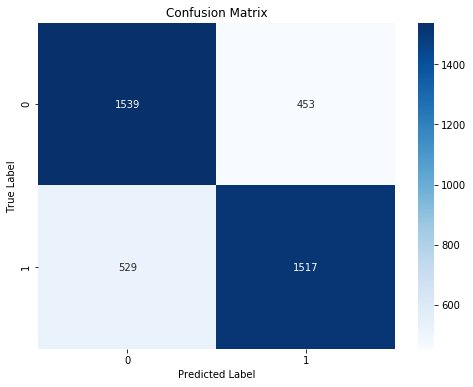

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.76      1992
           1       0.77      0.74      0.76      2046

    accuracy                           0.76      4038
   macro avg       0.76      0.76      0.76      4038
weighted avg       0.76      0.76      0.76      4038



In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns

# Plot training & validation accuracy values
def plot_accuracy(history):
    print("Available keys in history.history:", history.history.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training & validation loss values
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Print classification report
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

# Generating evaluation plots
def evaluate_model(model, X_val, y_val, history):
    predictions = np.argmax(model.predict(X_val), axis=1)
    y_val_true = np.argmax(y_val, axis=1)
    
    # Plot accuracy and loss
    plot_accuracy(history)
    plot_loss(history)
    
    # Plot ROC curve
    plot_roc_curve(y_val_true, predictions)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_val_true, predictions)
    
    # Print classification report
    print_classification_report(y_val_true, predictions)

# Call the evaluation function
evaluate_model(model_final, x_val, y_val, loss_history[0])
